# Reproducing Gunseli CDA Study (2019) - G vs B

In [1]:
import numpy as np
import pandas as pd
import glob
import pickle
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_eeglab

from scipy.io import loadmat

import os
import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Gunseli-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
triggers = dict();

triggers['5'] = [5] 
triggers['6'] = [6]

triggers['left'] = [10]
triggers['right'] = [20]
triggers['TBD'] = [30, 255]  # 255 is only for pp24 which doesn't have '30' but '255'

triggers['good'] = []
triggers['bad'] = []

# Labels
conds = ['5', '6']
sides = ['left', 'right', 'TBD']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['P8', 'PO8', 'O2']
chan_left = ['P7', 'PO7', 'O1']

# Epoc Information
epoch_length = 3.5
epoch_tmin = -0.5
baseline_corr = (-0.2, 0)

# # CDA main variable & Reports
cda_dict = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
folderpath = '/Users/nick/Documents/PhD/CDA Datasets/Gunseli 2019/'
#filepath = folderpath + 'raw data files/' + 'StratAtt_e2_LoadChans_pp11.set'

for filepath in glob.iglob(folderpath + 'raw data files/' + '*.set'):
    filename = filepath[filepath.rfind('/')+1:]
    print('Processing: ' + filename + '...')
    
    # 1. -- Load File --
    raw = read_raw_eeglab(filepath, preload=True)

    # Resample
    preproc = raw.resample(500)

    # 2. -- General Preprocess --
    # Keep only EEG channels and reference
    #raw = raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'])

    # Set Electrodes Locations
    #montage = mne.channels.make_standard_montage('biosemi64')
    #raw.set_montage(montage)

    # Filter
    preproc = preproc.filter(.1, 20., fir_design='firwin')

    # Get events
    events = mne.events_from_annotations(preproc)
    
    #preproc.plot(events=events[0], block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    # Use this for checksum & perf!
    #behavfilepath = folderpath + 'raw data files/' + 'subject-{}.csv'.format(filepath[filepath.rfind('pp')+2:filepath.rfind('.')])

    #behav = pd.read_csv(behavfilepath)  
    #behav_hl = behav['block_type'][(behav['block_type'] == 'low') | (behav['block_type'] == 'high')]

    # Redo Triggers based on annotation in file!
    new_triggers = copy.deepcopy(triggers)
    for k in new_triggers.keys():
        for i,t in enumerate(new_triggers[k]):
            if str(t) in events[1].keys():
                new_triggers[k][i] = events[1][str(t)]
    specific_events = get_specific_events(events[0], conds, sides, perfs, new_triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)

# Add time points to CDA for later use.
times = epochs_dict['5']['left']['good'].times

subreport = get_report(report, ['5','6'], ['left','right'], ['good'], [])
report

Processing: StratAtt_e2_LoadChans_pp2.set...
Reading /Users/nick/Documents/PhD/CDA Datasets/Gunseli 2019/raw data files/StratAtt_e2_LoadChans_pp2.fdt
Reading 0 ... 2452479  =      0.000 ...  4789.998 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 85 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 91 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 490 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 65 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 99 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 85 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 88 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 85 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 474 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
69 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 69 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 88 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 79 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Data file name in EEG.data (StratAtt_e2_LoadChans_pp29set.fdt) is incorrect, the file name must have changed on disk, using the correct file name (StratAtt_e2_LoadChans_pp29.fdt).
  raw = read_raw_eeglab(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 80 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 82 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 92 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
69 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 69 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 76 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
87 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 87 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 84 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 86 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 98 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(filepath, preload=True)
/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6', 'boundary']
Total: 489 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
69 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data fo

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '255', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 86 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 74 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 86 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 90 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 85 events 

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_1432/2407015838.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
Total: 500 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.5, tmax:3.5, baseline=(-0.2, 0)
---------- 5-left-good -------------
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 76 events 

,5,6,left,right,TBD,good,bad,5-left,5-left-good,5-good,...,6-left-bad,6-bad,6-right,6-right-good,6-right-bad,6-TBD,6-TBD-good,6-TBD-bad,checksum,notes
StratAtt_e2_LoadChans_pp2.set,250,250,160,159,181,500,0,85,85,250,...,0,0,81,81,0,94,94,0,1,
StratAtt_e2_LoadChans_pp3.set,250,250,168,171,161,500,0,91,91,250,...,0,0,95,95,0,78,78,0,1,
StratAtt_e2_LoadChans_pp4.set,240,250,150,171,169,490,0,65,65,240,...,0,0,89,89,0,76,76,0,1,
StratAtt_e2_LoadChans_pp5.set,250,250,188,140,172,500,0,99,99,250,...,0,0,77,77,0,84,84,0,1,
StratAtt_e2_LoadChans_pp7.set,250,250,167,186,147,500,0,85,85,250,...,0,0,97,97,0,71,71,0,1,
StratAtt_e2_LoadChans_pp6.set,250,250,171,163,166,500,0,88,88,250,...,0,0,73,73,0,94,94,0,1,
StratAtt_e2_LoadChans_pp13.set,250,250,158,163,179,500,0,85,85,250,...,0,0,91,91,0,86,86,0,1,
StratAtt_e2_LoadChans_pp12.set,224,250,147,143,184,474,0,69,69,224,...,0,0,73,73,0,99,99,0,1,
StratAtt_e2_LoadChans_pp10.set,250,250,173,161,166,500,0,88,88,250,...,0,0,82,82,0,83,83,0,1,
StratAtt_e2_LoadChans_pp11.set,250,250,167,151,182,500,0,79,79,250,...,0,0,65,65,0,97,97,0,1,


## 4. Plot CDA Data - Grand CDA Average

In [3]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():
        ## ====== Manual Cleanup ========
        # TODO: Skip only 1 side.
        # TODO: Look at pp24 cue 6
        # TODO: Look at pp18 cue 5
        if (f == 'StratAtt_e2_LoadChans_pp11.set') or (f == 'StratAtt_e2_LoadChans_pp18.set' and cond == '5') or (f == 'StratAtt_e2_LoadChans_pp24.set' and cond == '6'):
        #if (f == 'StratAtt_e2_LoadChans_pp11.set'):# or (f == 'StratAtt_e2_LoadChans_pp18.set') or (f == 'StratAtt_e2_LoadChans_pp24.set'):
            print('Manual Skip...')
            continue
        
        perf = 'good'
        ldict = cda_dict[f][cond]['left']
        rdict = cda_dict[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict[f][cond]['left']['good'] + cda_dict[f][cond]['right']['good'])/2
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
            
        #print("Processing CDA ({}): {}-{} = {}, {}-{} = {}".format(f, cond, 'left', len(ldict), cond, 'right', len(rdict)))

Manual Skip...
Manual Skip...
Manual Skip...
Manual Skip...


## Final CDA figure from Gunseli 2019

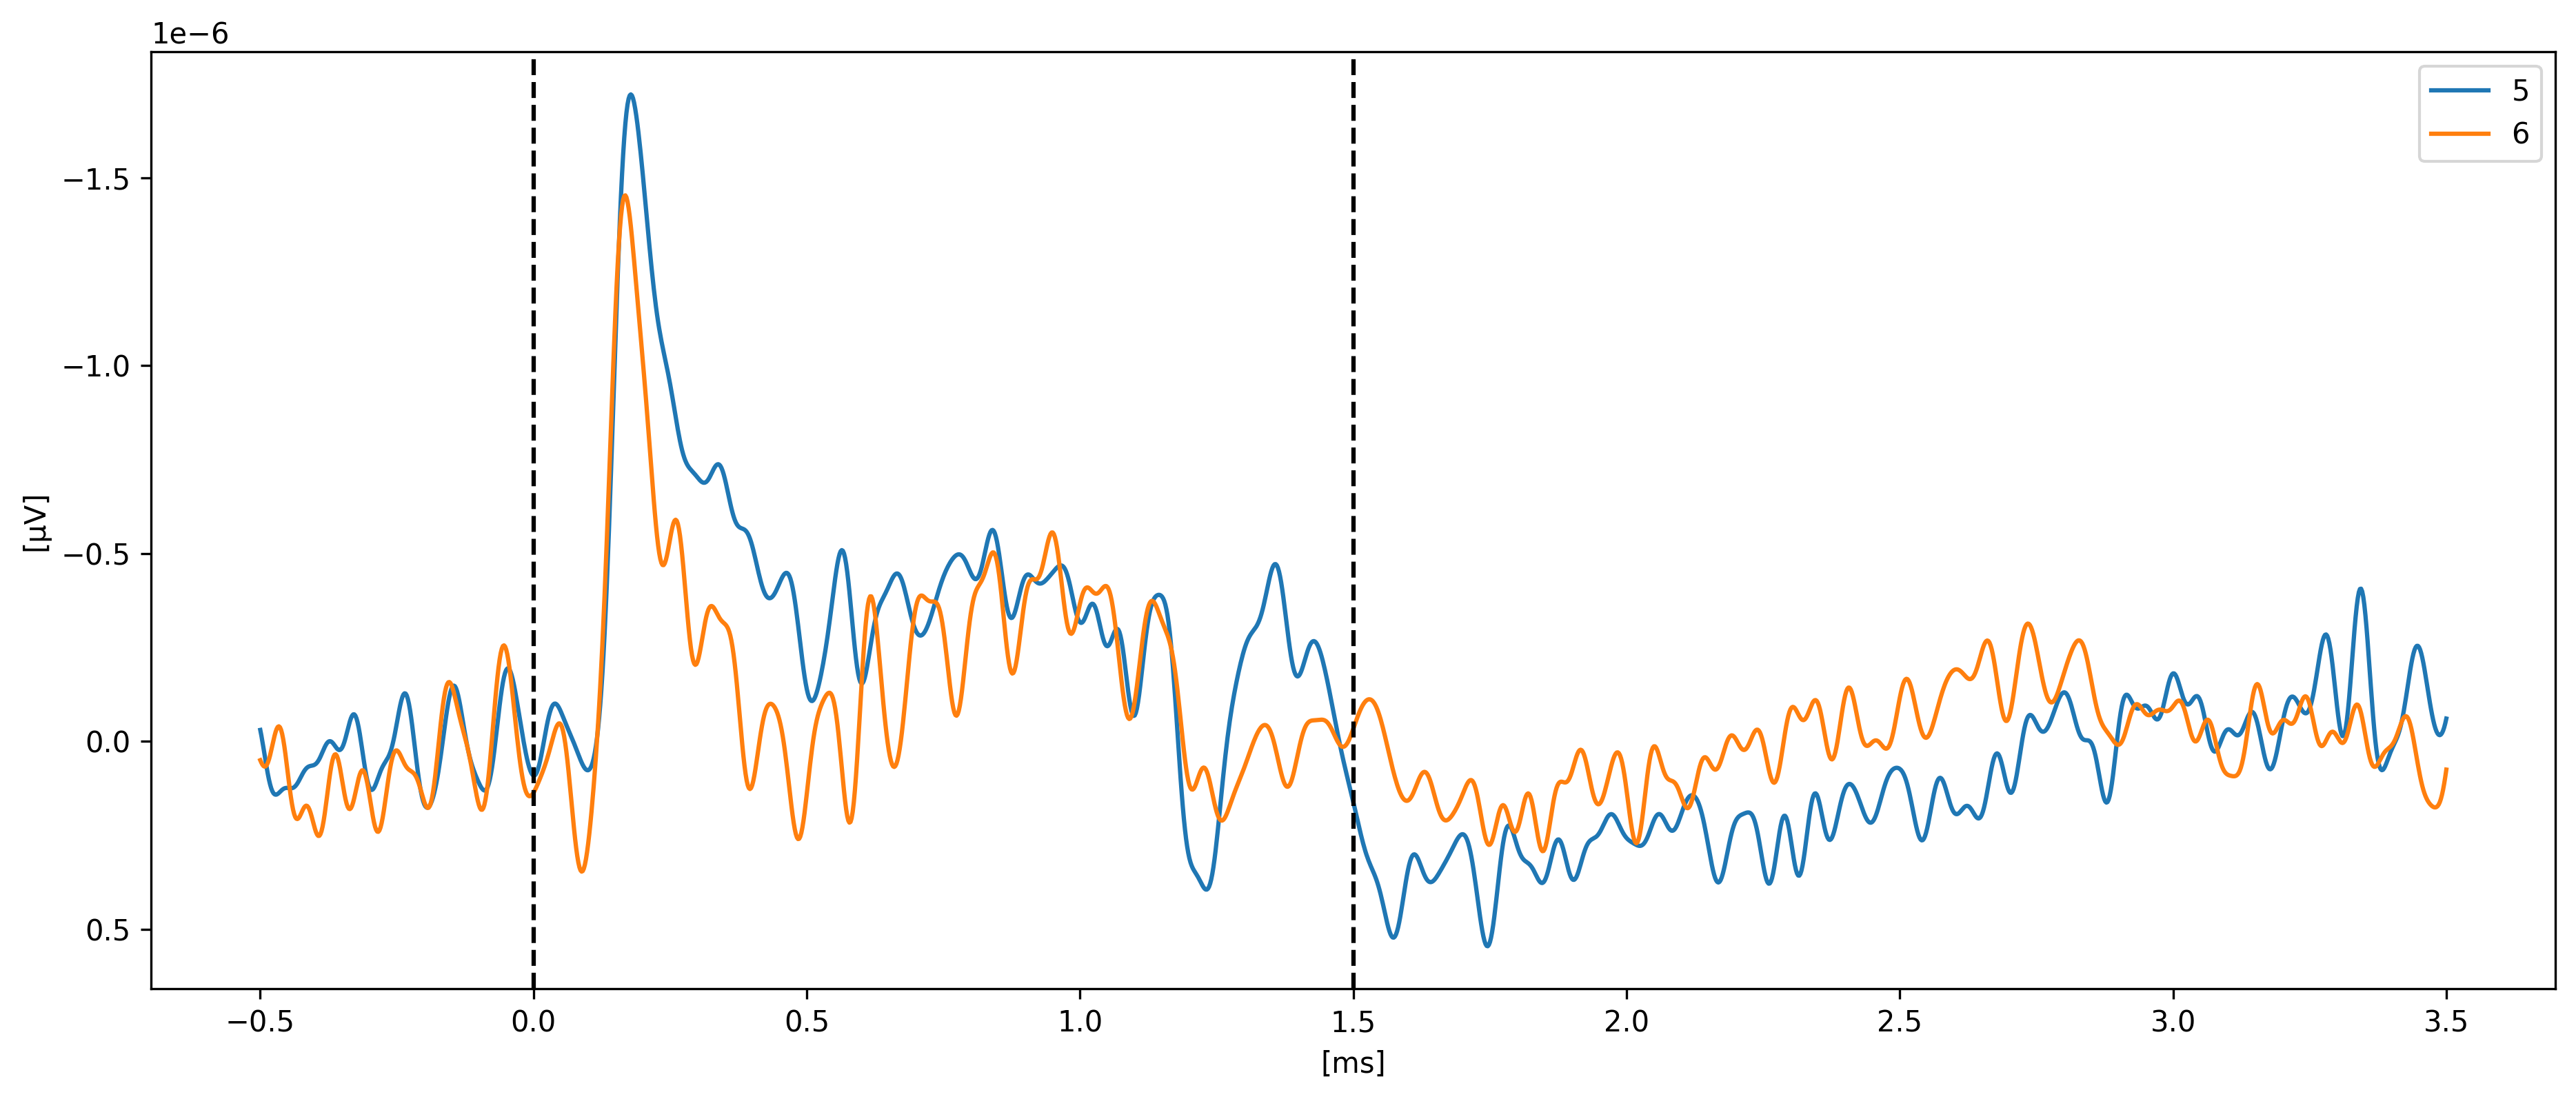

In [4]:
plt.figure(figsize=(15, 6), dpi=300)
plt.plot(times, cda_all['5'].mean(0), label='5')
plt.plot(times, cda_all['6'].mean(0), label='6')

plt.axvline(x=0, color='k', linestyle='--')
plt.axvline(x=1.5, color='k', linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
plt.show()
#plt.savefig("./img/Gunseli-2019_CDA-reprod.jpg", dpi=300)

## The difference between the paper and the graph below:
#1 - No subject rejected here.  (only 1 above, removed from the 15-25)
#2 - No artifact removal!
#3 - No Channel interpolation for noisy channel.
#4 - Not a 6Hz Low Pass filter at for their final graph.